Author: Joshua <br />
Summary: Find travel time errors for not only the response time, but the serve time, hospital drive time and return time.

In [17]:
import csv
import collections
import pandas as pd
import numpy as np
import math
import json
import matplotlib.pyplot as plt
import seaborn as sns

## load the data

In [35]:
hosp = np.genfromtxt('../Input_Data/calls_w_StnHospTimes.csv', delimiter=",", dtype=str)
#f_wkc = np.genfromtxt('Input_Data/Full_WeekdayCalls.csv', delimiter=",", dtype=str)
#wkc = np.genfromtxt('Input_Data/WeekdayCalls.csv', delimiter=",", dtype=str)
a_i = np.genfromtxt('../Input_Data/austin_incidents.csv', delimiter=",", dtype=str)
#a_test_call = np.genfromtxt('Input_Data/austin_test_calls.csv', delimiter=",", dtype=str)
clean = np.genfromtxt('../Input_Data/cleaned_data.csv', delimiter=",", dtype=str) #210k x 17
backend = np.genfromtxt('../Input_Data/backend_calls.csv', delimiter=",", dtype=str) #30k
peakHours = np.genfromtxt('../Output_Data/peakhours.csv', delimiter=",", dtype=str)

In [36]:
peakHours = np.genfromtxt('../Output_Data/peakhours.csv', delimiter=",", dtype=str)
print(peakHours.shape)

(103955, 17)


In [37]:
print(clean[0])
print(backend[0])
print(backend[0:10,-2])

['' 'IncidentForeignKey' 'Radio_Name' 'Longitude_At_Assign_Time'
 'Latitude_At_Assign_Time' 'Time_Assigned' 'Time_Enroute'
 'Time_ArrivedAtScene' 'Time_Depart_Scene' 'Time_Arrive_Destination'
 'Time_Available' 'Time_Call_Cleared' 'Call_Disposition'
 'Longitude_Of_Emergency' 'Latitude_Of_Emergency' 'transport_time'
 'grid_time']
['' 'Unnamed: 0' 'IncidentForeignKey' 'Radio_Name'
 'Longitude_At_Assign_Time' 'Latitude_At_Assign_Time' 'Time_Assigned'
 'Time_Enroute' 'Time_ArrivedAtScene' 'Time_Depart_Scene'
 'Time_Arrive_Destination' 'Time_Available' 'Time_Call_Cleared'
 'Call_Disposition' 'Longitude_Of_Emergency' 'Latitude_Of_Emergency'
 'transport_time' 'grid_time' 'Time_Arrived' 'timedelta' 'arrival_seconds'
 'interarrival_seconds' 'neighborhood' 'dow']
['neighborhood' '83' '38' '129' '107' '113' '51' '76' '67' '52']


In [38]:
#make sure the hospital times are the same at different times.
# hosp = np.genfromtxt('Input_Data/calls_w_StnHospTimes.csv', delimiter=",", dtype=str)
# hosp
# hosp.shape #(210108, 67)
# hosp[:,3] #neighborhood
# hosp[:,5] #
# where67 = np.where(hosp[:,3] == "67")
# hosp[where67[0],8]

## calculate times with calendar difference

In [39]:
print(backend[0,6]) #Time_Assigned
backend[0,7] #Time_Enroute
backend[0,8] #Time_ArrivedAtScene
backend[0,9] #Time_Depart_Scene
backend[0,10] #Time_Arrive_Destination
backend[0,11] #Time_Available
backend[0,12] #Time_Call_Cleared
backend[0,16] #transport_time
backend[0,17] #grid_time

print(peakHours[0,5]) #Time_Assigned
print(peakHours[0,6]) #Time_Enroute
print(peakHours[0,7]) #Time_ArrivedAtScene

print(clean[0,8]) #Time_Depart_Scene
print(clean[0,9]) #Time_Arrive_Destination
print(clean[0,10]) #Time_Available
print(clean[0,11]) #Time_Call_Cleared
print(clean[0,16]) #grid_time



Time_Assigned
Time_Assigned
Time_Enroute
Time_ArrivedAtScene
Time_Depart_Scene
Time_Arrive_Destination
Time_Available
Time_Call_Cleared
grid_time


####  small example

In [40]:
i = 1
Time_Assigned = csv2calendar(i,6)
Time_Enroute = csv2calendar(i,7)
Time_ArrivedAtScene = csv2calendar(i,8)
Time_Depart_Scene = csv2calendar(i,9)
Time_Arrive_Destination = csv2calendar(i,10)
Time_Available = csv2calendar(i,11)
Time_Call_Cleared = csv2calendar(i,12)
if Time_ArrivedAtScene == -1 or Time_Enroute == -1:
        hist_station2call[i] = -1
else:    
    #print(Time_ArrivedAtScene - Time_Enroute.seconds / 60)
    hist_station2call.append((Time_ArrivedAtScene - Time_Enroute).seconds / 60)

In [41]:
import math
from datetime import *; from dateutil.relativedelta import *
import calendar
def csv2calendar(index,type_event):
    time1 = peakHours[index,type_event-1]  #note backend and clean data sets are off by one index
    #time1 = backend[index,type_event]
    #time1 = clean[index,type_event-1]
    if time1 == "":
        return -1
    [ymd,hmm] = time1.split()
    [y,m,d] = ymd.split('-')
    [h,minu,sec] = hmm.split(":")
    y = int(y)
    m = int(m)
    d = int(d)
    h = int(h)
    minu = int(minu)
    sec = math.floor(float(sec))
    timearrive = datetime(y, m, d, h, minu, sec)
    return timearrive

In [42]:
clean[4,-5]

'False Alarm Call'

In [43]:
print(clean[0,5]) #Time_Assigned
print(clean[0,6]) #Time_Enroute
print(clean[0,7]) #Time_ArrivedAtScene
print(clean[0,8]) #Time_Depart_Scene
print(clean[0,9]) #Time_Arrive_Destination
print(clean[0,10]) #Time_Available
print(clean[0,11]) #Time_Call_Cleared
print(clean[0,16]) #grid_time

Time_Assigned
Time_Enroute
Time_ArrivedAtScene
Time_Depart_Scene
Time_Arrive_Destination
Time_Available
Time_Call_Cleared
grid_time


In [44]:
nsamples = len(peakHours) #len(clean) #= 1000
hist_setUpTime = [] #np.zeros([10,1])
hist_station2call = []
hist_onSceneTime = []
hist_call2hospital = []
hist_hospital2station = []
end = np.zeros([10,1])

for i in range(1,nsamples):
    #print(i)
    Time_Assigned = csv2calendar(i,6)
    Time_Enroute = csv2calendar(i,7)
    Time_ArrivedAtScene = csv2calendar(i,8)
    Time_Depart_Scene = csv2calendar(i,9)
    Time_Arrive_Destination = csv2calendar(i,10)
    Time_Available = csv2calendar(i,11)
    Time_Call_Cleared = csv2calendar(i,12)
    #print(str(Time_Assigned) + "\n" + str(Time_Enroute) + "\n" + str(Time_ArrivedAtScene) + "\n"+ str(Time_Depart_Scene) + "\n"+ str(Time_Arrive_Destination) + "\n"+ str(Time_Available) + "\n"+ str(Time_Call_Cleared))

    #callAssignedTime
    if Time_Assigned == -1 or Time_Enroute == -1:
        hist_setUpTime.append(0)
    else: 
        #print(str(Time_Enroute) + "-" + str(Time_Assigned))
        hist_setUpTime.append((Time_Enroute - Time_Assigned).seconds / 60)
    #station2call
    if Time_ArrivedAtScene == -1 or Time_Enroute == -1:
        hist_station2call.append(0)
    else:    
        #print(Time_ArrivedAtScene - Time_Enroute.seconds / 60)
        hist_station2call.append((Time_ArrivedAtScene - Time_Enroute).seconds / 60)
    
    #on_scene_time
    if Time_Depart_Scene == -1 or Time_ArrivedAtScene == -1:
        hist_onSceneTime.append(0)
    else:    
        hist_onSceneTime.append((Time_Depart_Scene - Time_ArrivedAtScene).seconds / 60)
    
    #call2hospital
    if Time_Arrive_Destination == -1 or Time_Enroute == -1:
        hist_call2hospital.append(0)
    else:  
        hist_call2hospital.append((Time_Arrive_Destination - Time_Depart_Scene).seconds / 60)
        
    #hospital2station
    if Time_Available == -1 or Time_Arrive_Destination == -1:
        hist_hospital2station.append(0)
    else:  
        hist_hospital2station.append((Time_Available - Time_Arrive_Destination).seconds / 60)    

In [45]:
hist_setUpTime.insert(0,"")
hist_station2call.insert(0,"")
hist_onSceneTime.insert(0,"")
hist_call2hospital.insert(0,"")
hist_hospital2station.insert(0,"")

<AxesSubplot:ylabel='Density'>

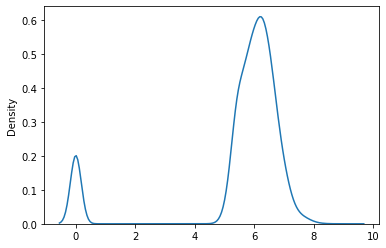

In [53]:
import seaborn as sns
sns.kdeplot(peakHours[1:,-1].astype(float) / 60)

In [46]:
import math

df = pd.DataFrame(peakHours)
df["callAssign2TimeEnroute"] = hist_setUpTime
df["station2call"] = hist_station2call
df["onSceneTime"] = hist_onSceneTime
df["call2HospitalTime"] = hist_call2hospital
df["hospital2StationTime"] = hist_hospital2station
df.to_csv('peakHours.csv')
df

,0,1,2,3,4,5,6,7,8,9,...,12,13,14,15,16,callAssign2TimeEnroute,station2call,onSceneTime,call2HospitalTime,hospital2StationTime
0,,IncidentForeignKey,Radio_Name,Longitude_At_Assign_Time,Latitude_At_Assign_Time,Time_Assigned,Time_Enroute,Time_ArrivedAtScene,Time_Depart_Scene,Time_Arrive_Destination,...,Call_Disposition,Longitude_Of_Emergency,Latitude_Of_Emergency,transport_time,grid_time,,,,,
1,1,23397873,M09,-97.972866,30.333385,2019-01-01 19:43:36.000,2019-01-01 19:45:27.030,2019-01-01 19:48:39.770,2019-01-01 20:19:00.870,2019-01-01 20:24:43.093,...,Baylor Scott & White - Lakeway,-97.961,30.325,192,321.27507045599737,1.85,3.2,30.35,5.716667,26.483333
2,3,23408585,DM03,-97.751235,30.246114,2019-01-03 14:20:41.000,2019-01-03 14:20:54.110,2019-01-03 14:27:27.613,,,...,False Alarm Call,-97.777,30.251,393,344.47756370270764,0.216667,6.55,0,0,0
3,4,23408585,DMO02,-97.751966,30.245411,2019-01-03 14:20:58.117,2019-01-03 14:20:58.140,2019-01-03 14:26:59.083,,,...,Dual w/ other ATCEMS Unit,-97.777,30.251,360,344.47756370270764,0.0,6.016667,0,0,0
4,8,23439455,M10,-97.74259,30.418169,2019-01-07 17:28:48.000,2019-01-07 17:30:12.067,2019-01-07 17:47:53.030,,,...,False Alarm Call,-97.747,30.407,1060,354.7832311645281,1.4,17.683333,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103950,279971,27262452,CHP11,-97.769524,30.231354,2020-06-29 14:57:29.090,2020-06-29 14:57:29.090,2020-06-29 15:33:16.447,,,...,Other,-97.654,30.379,2147,427.73106999831066,0.0,35.783333,0,0,0
103951,279972,27317236,CHP11,-97.774368,30.224984,2020-07-07 10:03:20.000,2020-07-07 10:03:55.657,2020-07-07 11:17:14.023,,,...,Other,-97.789,30.204,4398,337.8117335859198,0.583333,73.316667,0,0,0
103952,279973,27336505,CHP21,-97.734738,30.275694,2020-07-10 09:10:57.000,2020-07-10 09:11:46.533,2020-07-10 09:22:19.883,,,...,Other,-97.767,30.19,633,391.0035898770869,0.816667,10.55,0,0,0
103953,279974,27413735,CHP08,-97.770123,30.191624,2020-07-22 13:10:46.880,2020-07-22 13:10:46.880,2020-07-22 13:42:29.970,,,...,CHP Intervention(CHP use only),-97.694,30.227,1903,391.2125183986271,0.0,31.716667,0,0,0


In [47]:
df.to_csv('../Input_Data/processed_data.csv')

In [48]:
print(len(hist_setUpTime))
print(len(hist_station2call))
print(len(hist_onSceneTime))
print(len(hist_call2hospital))
print(len(hist_hospital2station))

103955
103955
103955
103955
103955


In [35]:
print("hist_setUpTime: " + str(np.mean(hist_setUpTime)))
print("hist_station2call: " + str(np.mean(hist_station2call)))
print("hist_onSceneTime: " + str(np.mean(hist_onSceneTime)))
print("hist_call2hospital: " + str(np.mean(hist_call2hospital)))
print("hist_hospital2station: " + str(np.mean(hist_hospital2station)))

np.mean(hist_setUpTime) + np.mean(hist_station2call) + np.mean(hist_onSceneTime) + np.mean(hist_call2hospital) + np.mean(hist_hospital2station)

hist_setUpTime: 1.0511059345899159
hist_station2call: 7.114469834916365
hist_onSceneTime: 22.01469758362178
hist_call2hospital: 14.622384170781455
hist_hospital2station: 26.888785358464983


71.6914428823745

## custom bins for xinyu 
### 3 periods before March 17 2020, between, and after Nay 1

In [64]:
csv2calendar(i,6).month


In [74]:
period_setUpTime = [[],[],[]] #np.zeros([10,1])
period_station2call = [[],[],[]]
period_onSceneTime = [[],[],[]]
period_call2hospital = [[],[],[]]
period_hospital2station = [[],[],[]]

for i in range(1,nsamples-1):
    #print(i)
    Time_Assigned = csv2calendar(i,6)
    if Time_Assigned.year == 2019 or Time_Assigned.month < 3 :
        period_setUpTime[0].append(hist_setUpTime[i])
        period_station2call[0].append(hist_station2call[i])
        period_onSceneTime[0].append(hist_onSceneTime[i])
        period_call2hospital[0].append(hist_call2hospital[i])
        period_hospital2station[0].append(hist_hospital2station[i])     
    elif Time_Assigned.month <= 3 and Time_Assigned.day <= 16:
        period_setUpTime[0].append(hist_setUpTime[i])
        period_station2call[0].append(hist_station2call[i])
        period_onSceneTime[0].append(hist_onSceneTime[i])
        period_call2hospital[0].append(hist_call2hospital[i])
        period_hospital2station[0].append(hist_hospital2station[i])    
    elif Time_Assigned.month <= 5 and Time_Assigned.day <= 16:
        period_setUpTime[1].append(hist_setUpTime[i])
        period_station2call[1].append(hist_station2call[i])
        period_onSceneTime[1].append(hist_onSceneTime[i])
        period_call2hospital[1].append(hist_call2hospital[i])
        period_hospital2station[1].append(hist_hospital2station[i])
    else:
        period_setUpTime[2].append(hist_setUpTime[i])
        period_station2call[2].append(hist_station2call[i])
        period_onSceneTime[2].append(hist_onSceneTime[i])
        period_call2hospital[2].append(hist_call2hospital[i])
        period_hospital2station[2].append(hist_hospital2station[i])
    

In [75]:
print(len(period_onSceneTime[0]))
print(len(period_onSceneTime[1]))
print(len(period_onSceneTime[2]))

46805
2458
11695


(0.0, 20.0)

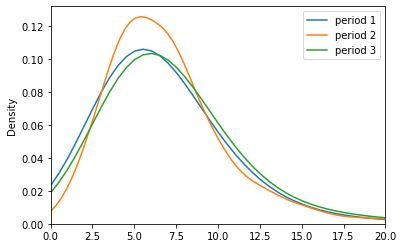

In [90]:
sns.kdeplot(period_station2call[0], clip = [0,100])
sns.kdeplot(period_station2call[1], clip = [0,100])
sns.kdeplot(period_station2call[2], clip = [0,100])
plt.legend(["period 1", "period 2", "period 3"])
plt.xlim([0,20])

(0.0, 100.0)

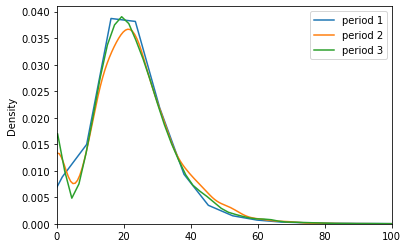

In [86]:
import seaborn as sns
sns.kdeplot(period_onSceneTime[0], label = "period 1")
sns.kdeplot(period_onSceneTime[1])
sns.kdeplot(period_onSceneTime[2])
plt.legend(["period 1", "period 2", "period 3"])
plt.xlim([0,100])


(array([1.02e+03, 4.00e+00, 5.00e+00, 7.00e+00, 2.00e+01, 4.70e+01,
        7.90e+01, 1.19e+02, 1.22e+02, 1.85e+02, 2.36e+02, 2.62e+02,
        2.88e+02, 3.45e+02, 4.38e+02, 3.97e+02, 4.48e+02, 4.11e+02,
        4.97e+02, 4.67e+02, 4.87e+02, 4.64e+02, 3.97e+02, 4.10e+02,
        3.98e+02, 3.66e+02, 3.62e+02, 3.11e+02, 3.10e+02, 2.67e+02,
        2.63e+02, 2.14e+02, 2.34e+02, 1.74e+02, 1.58e+02, 1.69e+02,
        1.39e+02, 1.11e+02, 1.10e+02, 8.50e+01, 7.40e+01, 7.70e+01,
        7.60e+01, 7.10e+01, 6.50e+01, 5.00e+01, 5.90e+01, 4.10e+01,
        3.60e+01, 2.60e+01, 2.00e+01, 2.80e+01, 2.40e+01, 2.00e+01,
        1.70e+01, 1.40e+01, 1.60e+01, 1.20e+01, 1.10e+01, 8.00e+00,
        1.10e+01, 1.20e+01, 9.00e+00, 1.10e+01, 1.30e+01, 6.00e+00,
        4.00e+00, 0.00e+00, 3.00e+00, 8.00e+00, 3.00e+00, 2.00e+00,
        3.00e+00, 4.00e+00, 1.00e+00, 3.00e+00, 3.00e+00, 2.00e+00,
        3.00e+00, 1.00e+00, 0.00e+00, 1.00e+00, 1.00e+00, 0.00e+00,
        1.00e+00, 2.00e+00, 1.00e+00, 0.00e+00, 

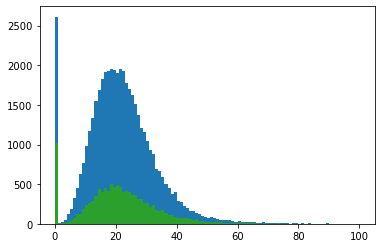

In [78]:
plt.hist(period_onSceneTime[0],range = (0,100), bins = 100,)
plt.hist(period_onSceneTime[1],range = (0,100), bins = 100,)
plt.hist(period_onSceneTime[2],range = (0,100), bins = 100,)

#### Cleandata: (There are all these -1's)
hist_setUpTime: 1.1232053985191675 <br>
hist_station2call: 7.231526000244321 <br>
hist_onSceneTime: 12.654019935873944 <br>
hist_call2hospital: 7.752674986237172 <br>
hist_hospital2station: 15.294203112382416 <br>
44.05562943325702
#### Peakhours: 
hist_setUpTime: 1.0511059345899159 <br>
hist_station2call: 7.114469834916365 <br>
hist_onSceneTime: 21.952787119211273 <br>
hist_call2hospital: 14.560457301902373 <br>
hist_hospital2station: 26.8268584895859 <br>
71.50567868020583 <br>
#### Peakhours -1 -> 0:
hist_setUpTime: 1.0511059345899159 <br>
hist_station2call: 7.114469834916365 <br>
hist_onSceneTime: 22.01469758362178 <br>
hist_call2hospital: 14.622384170781455 <br>
hist_hospital2station: 26.888785358464983 <br>
71.6914428823745

## fitting lognormal service time

1435.0333333333333


(array([2.000e+00, 6.000e+00, 1.500e+01, 4.700e+01, 8.500e+01, 1.760e+02,
        3.090e+02, 4.830e+02, 6.410e+02, 8.350e+02, 1.072e+03, 1.359e+03,
        1.606e+03, 1.804e+03, 2.068e+03, 2.345e+03, 2.363e+03, 2.575e+03,
        2.686e+03, 2.775e+03, 2.626e+03, 2.684e+03, 2.598e+03, 2.501e+03,
        2.383e+03, 2.366e+03, 2.159e+03, 1.974e+03, 1.836e+03, 1.637e+03,
        1.569e+03, 1.427e+03, 1.346e+03, 1.202e+03, 1.101e+03, 8.910e+02,
        8.500e+02, 7.460e+02, 7.150e+02, 6.250e+02, 5.520e+02, 5.110e+02,
        4.530e+02, 3.590e+02, 3.400e+02, 2.900e+02, 2.560e+02, 2.280e+02,
        1.690e+02, 1.760e+02, 1.590e+02, 1.250e+02, 9.800e+01, 8.800e+01,
        9.000e+01, 7.900e+01, 6.100e+01, 6.900e+01, 4.100e+01, 3.100e+01,
        3.600e+01, 3.700e+01, 2.800e+01, 2.000e+01, 2.900e+01, 2.300e+01,
        2.300e+01, 1.400e+01, 2.000e+01, 7.000e+00, 1.200e+01, 7.000e+00,
        3.000e+00, 1.000e+00, 5.000e+00, 4.000e+00, 4.000e+00, 1.000e+00,
        2.000e+00, 2.000e+00, 2.000e+0

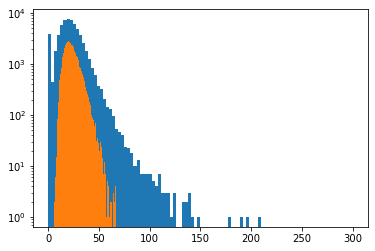

In [199]:
print(np.max(hist_onSceneTime))
#plt.hist(hist_onSceneTime, range = (0,200), bins = 100)
x = np.random.lognormal(3.0888,.3, len(hist_onSceneTime))
plt.hist(hist_onSceneTime, range = (0,300), bins = 100, log = True)
plt.hist(x, bins = 100, log = True) #,range = (0,300))

In [191]:
np.var(hist_onSceneTime)

240.21318124698533